#                      Real-Time Location System Case Study

##                          Lei Jiang, Kristen Rollins, Daniel Davieau

### requirement:
Include an introduction to explain the case study, explain the approach used to complete the case study and explain the output achieved.  Explanations of output should be included as close to the output or figures as possible.

List all references used, including the book by Nolan and Lang.


### write abstract, intro, ...
t="Timestamp" 

__id="MACofScanDevice"__ A unique ID of a network device.  The ﬁrst of these 3 sets of pairs of digits, i.e., mm:mm:mm, identiﬁes the manufacturer of the equipment. The second set of 3 pairs (the ss) identiﬁes the particular piece of equipment, both the model and the unique d
evice. 

__pos="RealPosition"__ the physical coordinate of the scanning device 

__degree="orientation"__ the orientation of the user carrying the scanning device in degrees

__MACofResponse1="SignalStrengthValue,Frequency,Mode"__ MACaddressofarespondingpeer(e.g.,anaccesspointoradevice in adhoc mode) with the corresponding values for signal strength in dBm (Decibel-milliwatts), the channel frequency and its mode (access point = 3, device in adhoc mode = 1)

__MACofResponseN="SignalStrengthValue,Frequency,Mode"__ "..."

__See formula on Question 12 for weighting for final question.__

### rephrase the questions
#### Conduct a more thorough data analysis into these two MAC addresses including determining locations by using data corresponding to both MAC addresses.  Which of these two MAC addresses should be used and which should not be used for RTLS? Which MAC address yields the best prediction of location?  Does using data for both MAC addresses simultaneously yield more, or less, accurate prediction of location? (Note: this portion is derived from Exercise Q.9 in Nolan and Lang.)


#### weighted kNN




In [1]:
setwd("C:/Users/N1110/Desktop/QTW")
options(digits = 2)
# read in the entire file into a variable txt
# each line will be its own element
# txt = readLines("offline.final.trace.txt")

In [2]:
processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
if (length(tokens) == 10)
  return(NULL)
tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6,
byrow = TRUE), tmp)
}


# create a function that will round off to the nearest major angle
roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}



In [3]:
# re do our data read combining all the anlysis we did here there are 7 SEVEN macids
readData = 
  function(filename = 'offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }

In [4]:
offline = readData()

In [5]:
head(offline)

,time,posX,posY,orientation,mac,signal,rawTime,angle
,<dttm>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,2006-02-10 23:31:58,0,0,0,00:14:bf:b1:97:8a,-38,1.1e+12,0
2,2006-02-10 23:31:58,0,0,0,00:14:bf:b1:97:90,-56,1.1e+12,0
3,2006-02-10 23:31:58,0,0,0,00:0f:a3:39:e1:c0,-53,1.1e+12,0
4,2006-02-10 23:31:58,0,0,0,00:14:bf:b1:97:8d,-65,1.1e+12,0
5,2006-02-10 23:31:58,0,0,0,00:14:bf:b1:97:81,-65,1.1e+12,0
6,2006-02-10 23:31:58,0,0,0,00:14:bf:3b:c7:c6,-66,1.1e+12,0


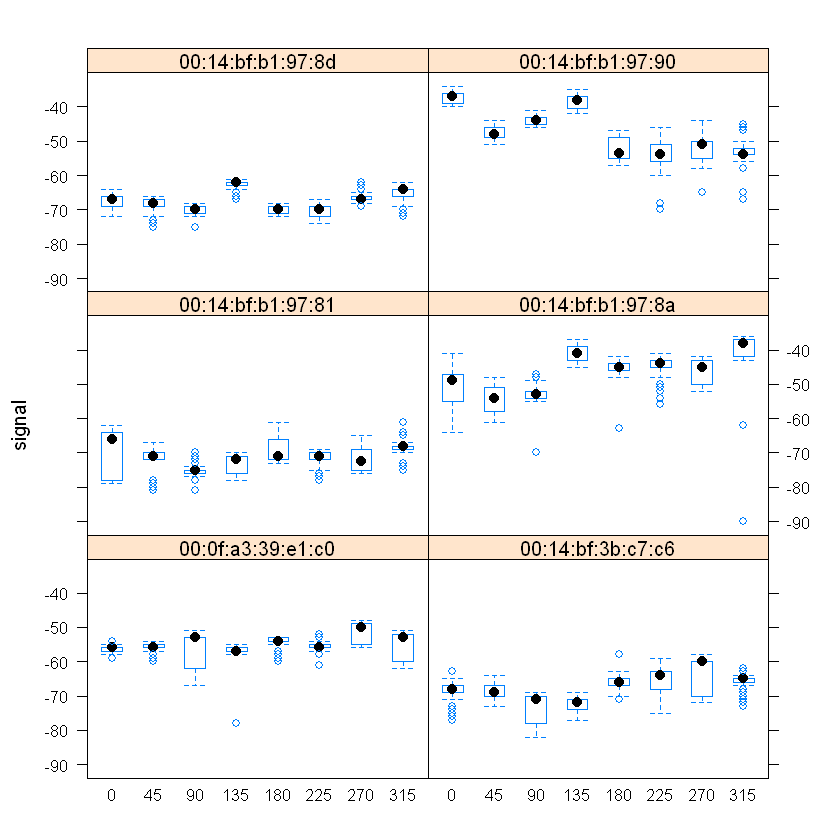

In [9]:
# plot signal strength for each device
# poor mac id 7.  he gets dropped
library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offline, 
       subset = posX == 2 & posY == 12 
                & mac != "00:0f:a3:39:dd:cd", 
       layout = c(2,3))

In [10]:
# examine signal strength overall
summary(offline$signal)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    -98     -67     -59     -60     -53     -25 

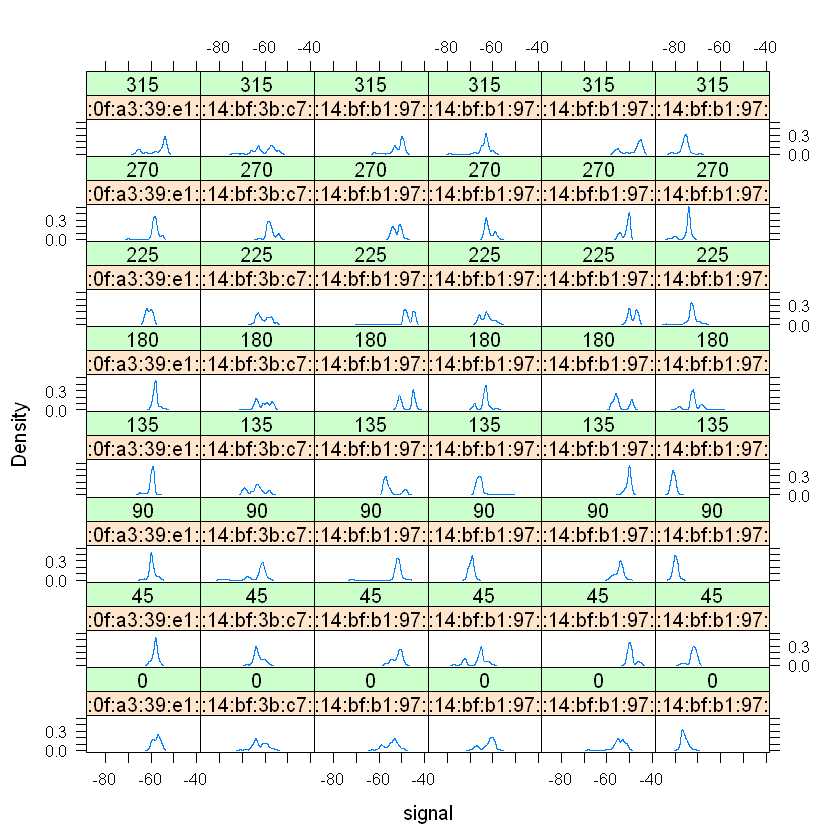

In [11]:
# density plots for SIX of the seven mac ids at X=24, Y=4
densityplot( ~ signal | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4 & 
                         mac != "00:0f:a3:39:dd:cd",
             bw = 0.5, plot.points = FALSE)

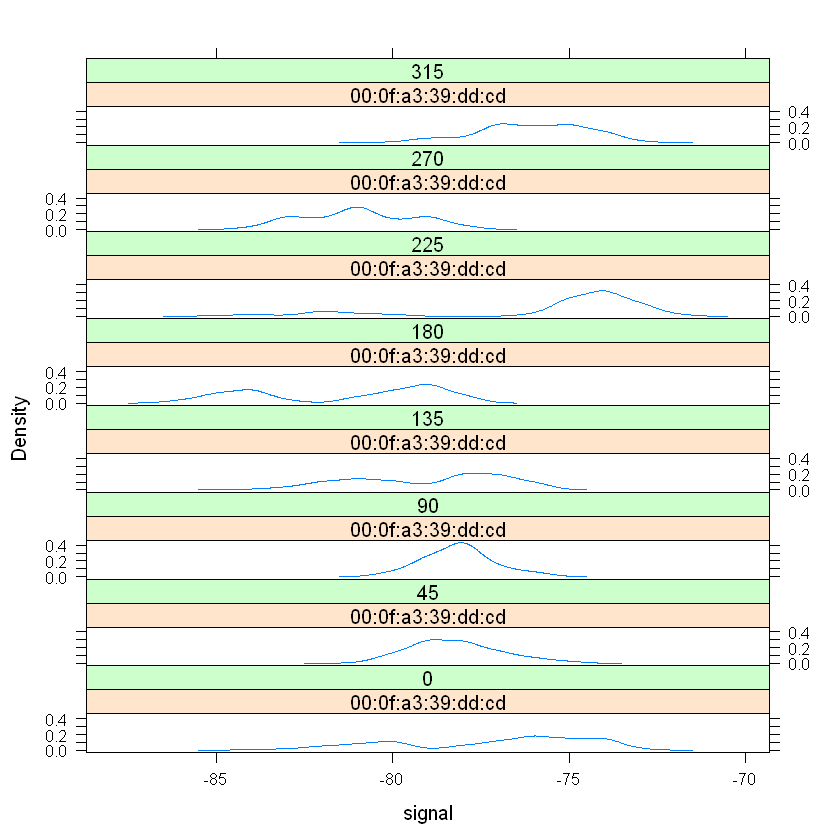

In [12]:
# density plots for the seventh mac ids at X=24, Y=4
# he was lonely
densityplot( ~ signal | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4 & 
                         mac == "00:0f:a3:39:dd:cd",
             bw = 0.5, plot.points = FALSE)

In [6]:
#Setup all the data using the data summary
offline$posXY = paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary = do.call("rbind", signalSummary)  

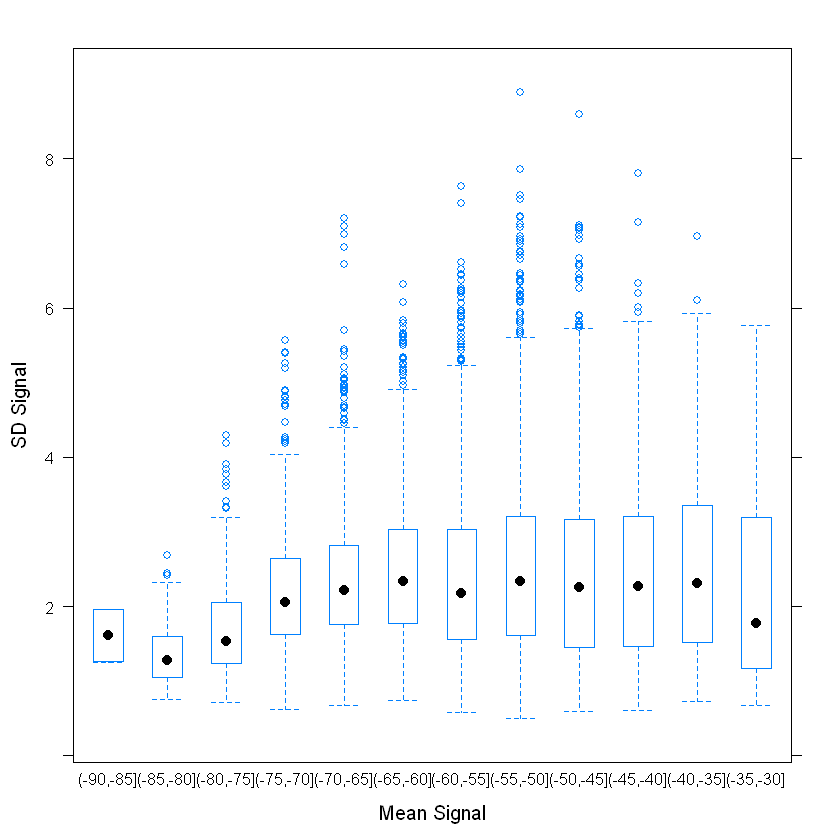

In [14]:
# look at the distribution of signal strength
breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary, 
       subset = mac != "00:0f:a3:39:dd:cd",
       xlab = "Mean Signal", ylab = "SD Signal")

In [7]:
subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81")

In [18]:
# here is where we drop a macid
offlineSummary0 = subset(offlineSummary, mac != subMacs[2])
offlineSummary1 = subset(offlineSummary, mac != subMacs[1])


,x,y
00:0f:a3:39:e1:c0,7.5,6.3
00:14:bf:b1:97:8a,2.5,-0.8
00:14:bf:3b:c7:c6,12.8,-2.8
00:14:bf:b1:97:90,1.0,14.0
00:14:bf:b1:97:8d,33.5,9.3
00:14:bf:b1:97:81,33.5,2.8


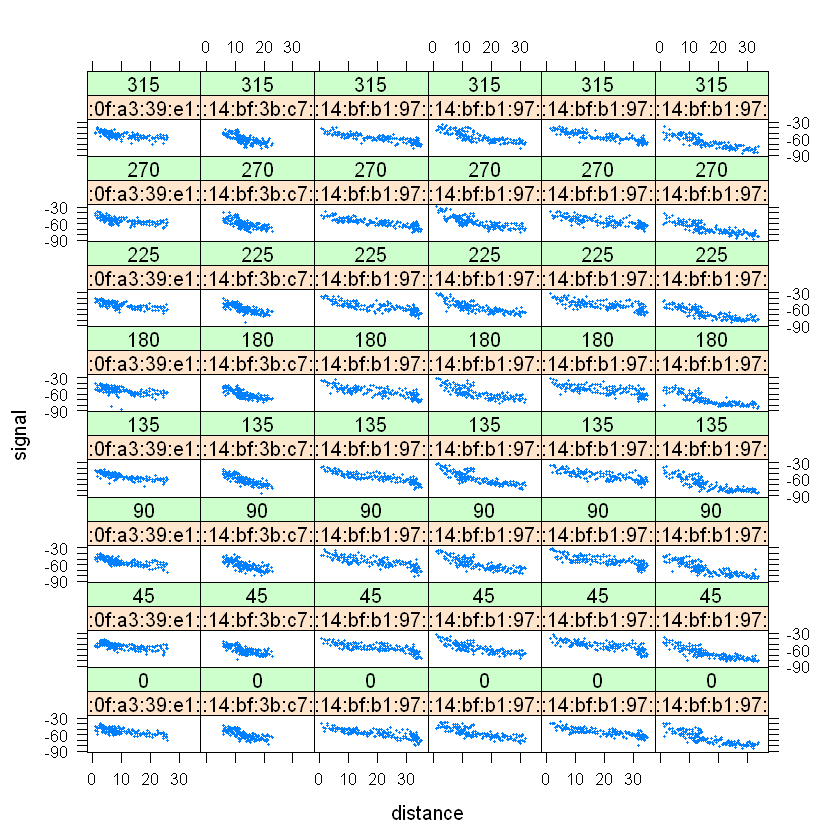

In [21]:
# Look at the access points
# signal strength vs distance

AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(subMacs[ -2 ], c("x", "y") ))

AP

diffs = offlineSummary[ , c("posX", "posY")] - 
          AP[ offlineSummary$mac, ]

offlineSummary$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2) # Eclidean 

xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")

### Signal strength vs Distance

#### We used Eclidean distance for the calculation. The plot above indicates that the signal strength is negative correlated with the distance. Therefore, the further the access point is, the weaker the signal is.

## Prepare the test data

In [8]:
# prepare the test data

# tally signal strength

macs = unique(offlineSummary$mac)
online = readData("online.final.trace.txt", subMacs = macs)

online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 7, #change from 6 to 7
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  

[1] 60

            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 704   0   0   0   0
  0.15-9.42    0   0 717   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 684   0   0
  0.47-8.2   701   0   0   0   0   0   0   0
  0.78-10.94 695   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 691   0   0   0

In [27]:
head(onlineSummary)

,posXY,posX,posY,orientation,angle,00:0f:a3:39:dd:cd,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0-0.05,0-0.05,0.00,0.05,130.5,135,-63,-52,-63,-62,-40,-63,-55
0.15-9.42,0.15-9.42,0.15,9.42,112.3,90,-66,-55,-74,-73,-48,-69,-47
0.31-11.09,0.31-11.09,0.31,11.09,230.1,225,-67,-52,-70,-70,-54,-69,-54
0.47-8.2,0.47-8.2,0.47,8.20,5.8,0,-74,-50,-64,-73,-46,-61,-50
0.78-10.94,0.78-10.94,0.78,10.94,348.3,0,-71,-53,-67,-67,-48,-65,-55
0.93-11.69,0.93-11.69,0.93,11.69,158.3,180,-70,-58,-70,-71,-44,-66,-47


In [9]:
# create data frame and functions to aggregate/select data with similar angles
dim(onlineSummary)

names(onlineSummary)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
#Notice that we handle the case of m odd and even separately. Also, we must
#map the angles to values in refs, e.g., -45 maps to 335 and 405 maps to 45,
#so we adjust angles with
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360
#After we have the subset of the desired angles, we select the observations
#from offlineSummary to analyze with
offlineSubset = 
  offlineSummary[ offlineSummary$angle %in% angles, ]

#Then we aggregate the signal strengths from these angles and create a data
#structure that is similar to that of onlineSummary. Rather than repeat the
#code again, we turn these computations into a helper function, which we
#call reshapeSS():
reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 7, #change from 6 to 7
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

[1] 60 12

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:dd:cd"
 [7] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[10] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [29]:
head(offlineSummary)

,time,posX,posY,orientation,mac,signal,rawTime,angle,posXY,medSignal,avgSignal,num,sdSignal,iqrSignal
,<dttm>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
7,2006-02-10 23:31:58,0,0,0.0,00:0f:a3:39:dd:cd,-75,1.1e+12,0,0-0,-67,-68,111,3.2,4.5
24512,2006-02-11 00:03:44,0,1,0.7,00:0f:a3:39:dd:cd,-73,1.1e+12,0,0-1,-70,-70,110,2.4,3.0
221777,2006-02-11 03:46:02,0,10,0.9,00:0f:a3:39:dd:cd,-69,1.1e+12,0,0-10,-67,-69,111,4.4,6.5
229191,2006-02-11 03:54:05,0,11,0.4,00:0f:a3:39:dd:cd,-72,1.1e+12,0,0-11,-73,-74,111,5.4,7.0
236493,2006-02-11 04:02:32,0,12,0.2,00:0f:a3:39:dd:cd,-72,1.1e+12,0,0-12,-70,-70,114,2.4,3.0
243546,2006-02-11 04:14:12,0,13,0.1,00:0f:a3:39:dd:cd,-69,1.1e+12,0,0-13,-74,-74,109,3.5,4.0


In [10]:
trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

train130 = selectTrain(130, offlineSummary, m = 3)

head(train130)

length(train130[[1]])

,posXY,posX,posY,00:0f:a3:39:dd:cd,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0-0,0-0,0,0,-72,-52,-66,-63,-36,-64,-55
0-1,0-1,0,1,-70,-53,-65,-64,-39,-65,-59
0-10,0-10,0,10,-70,-56,-66,-69,-45,-67,-50
0-11,0-11,0,11,-71,-55,-67,-70,-48,-67,-55
0-12,0-12,0,12,-69,-56,-70,-72,-45,-67,-50
0-13,0-13,0,13,-73,-55,-71,-73,-43,-69,-54


[1] 166

In [11]:
# here is our NN function.
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

In [12]:
# predict X-Y based on the the neasest k neighbors (default 3)
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}
                                    
# nearest 3 neighbors                                    
                                    
estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

# nearest neighbor
estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)

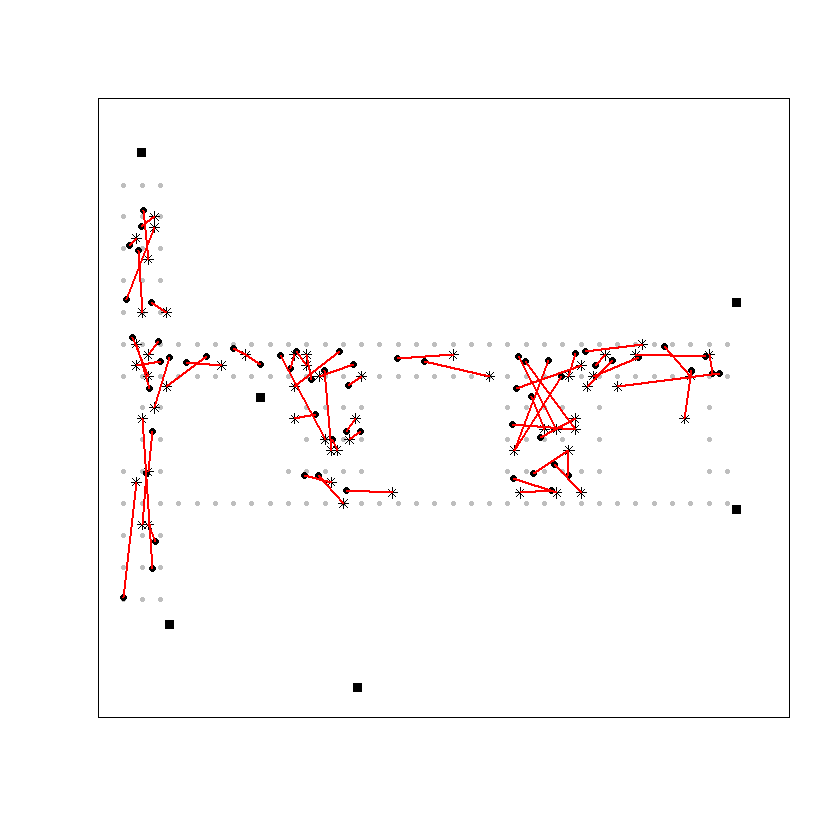

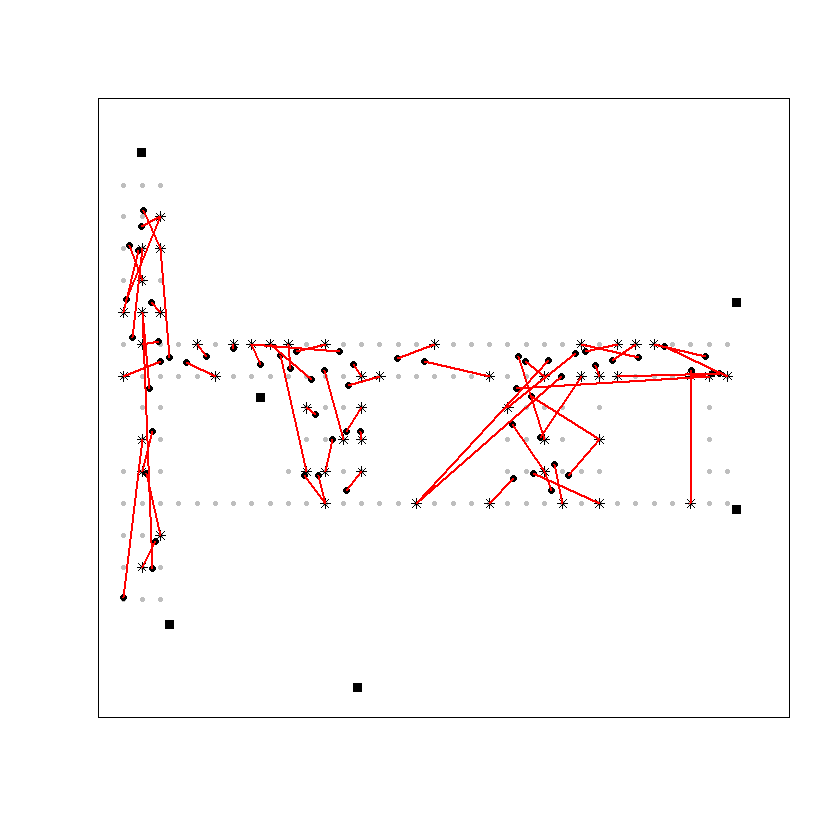

In [25]:
# predict and map errors
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

trainPoints = offlineSummary[ offlineSummary$angle == 0 & 
                              offlineSummary$mac == "00:0f:a3:39:e1:c0" ,
                        c("posX", "posY")]

# 3 NN

floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)


# 1 NN
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)

In [13]:

options(error = recover, warn = 1)
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)
v = 11
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}





[1] 510 244

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"


## Model1 with MAC address "00:0f:a3:39:dd:cd" removed

[1] 171

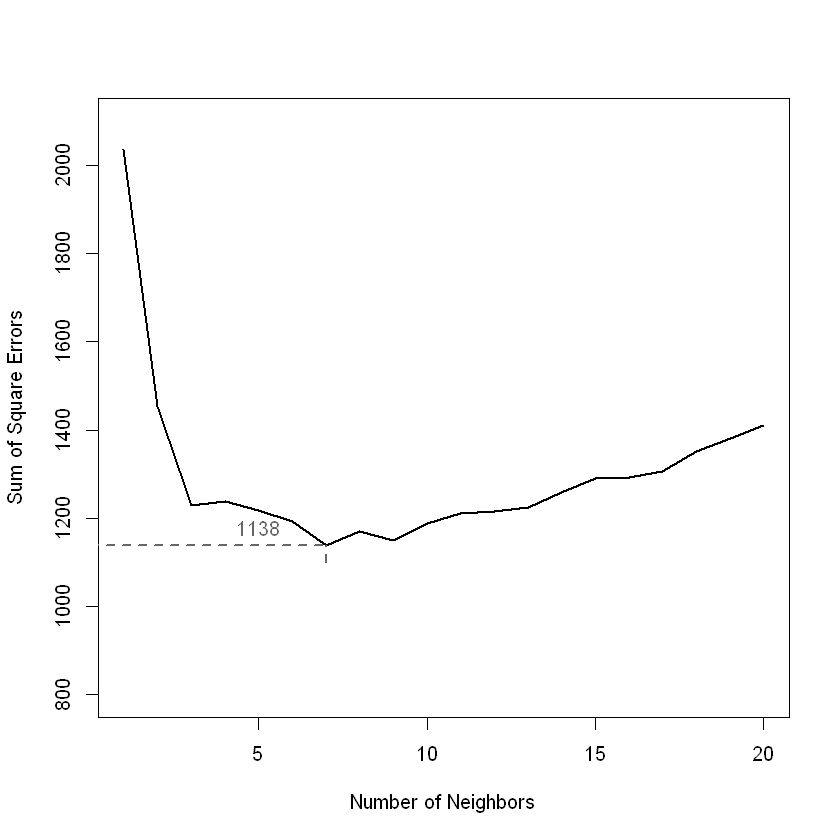

In [32]:
# train model with MAC address "00:0f:a3:39:dd:cd" removed
# up to 20 neighbors, 11 folds
# this one can run for a while (5-10 mins) -- 3 min
# this cell and the next are the same, but the angles change slightly!!
offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline, keepVars = keepVars, 
                            sampleAngle = FALSE) # set sampleAngle = FALSE  

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 1, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 1, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}


plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(800, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

In [33]:
estXYk5 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 1, k = 5)

calcError(estXYk5, actualXY)

[1] 417

In [41]:
# estXYk7 = predXY(newSignals = onlineSummary[ , 6:11], 
#                  newAngles = onlineSummary[ , 4], 
#                  offlineSummary, numAngles = 1, k = 7)

# calcError(estXYk7, actualXY)

## Model2 with MAC address "00:0f:a3:39:e1:c0" removed

In [22]:
#prepare the trainning data
# reset the training data set

offline = readData()

offline$posXY = paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary = do.call("rbind", signalSummary)  

subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81")
# here is where we drop a macid
offlineSummary = subset(offlineSummary, mac != subMacs[1])

In [42]:
head(offlineSummary)

,time,posX,posY,orientation,mac,signal,rawTime,angle,posXY,medSignal,avgSignal,num,sdSignal,iqrSignal
,<dttm>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
7,2006-02-10 23:31:58,0,0,0.0,00:0f:a3:39:dd:cd,-75,1.1e+12,0,0-0,-67,-68,111,3.2,4.5
24512,2006-02-11 00:03:44,0,1,0.7,00:0f:a3:39:dd:cd,-73,1.1e+12,0,0-1,-70,-70,110,2.4,3.0
221777,2006-02-11 03:46:02,0,10,0.9,00:0f:a3:39:dd:cd,-69,1.1e+12,0,0-10,-67,-69,111,4.4,6.5
229191,2006-02-11 03:54:05,0,11,0.4,00:0f:a3:39:dd:cd,-72,1.1e+12,0,0-11,-73,-74,111,5.4,7.0
236493,2006-02-11 04:02:32,0,12,0.2,00:0f:a3:39:dd:cd,-72,1.1e+12,0,0-12,-70,-70,114,2.4,3.0
243546,2006-02-11 04:14:12,0,13,0.1,00:0f:a3:39:dd:cd,-69,1.1e+12,0,0-13,-74,-74,109,3.5,4.0


In [30]:
trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

train130 = selectTrain(130, offlineSummary, m = 3)

head(train130)

length(train130[[1]])

,posXY,posX,posY,00:0f:a3:39:dd:cd,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0-0,0-0,0,0,-72,-66,-63,-36,-64,-55
0-1,0-1,0,1,-70,-65,-64,-39,-65,-59
0-10,0-10,0,10,-70,-66,-69,-45,-67,-50
0-11,0-11,0,11,-71,-67,-70,-48,-67,-55
0-12,0-12,0,12,-69,-70,-72,-45,-67,-50
0-13,0-13,0,13,-73,-71,-73,-43,-69,-54


[1] 166

In [31]:
# here is our NN function.
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

In [32]:
# predict X-Y based on the the neasest k neighbors (default 3)
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}
                                    
# nearest 3 neighbors                                    
                                    
estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

# nearest neighbor
estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)

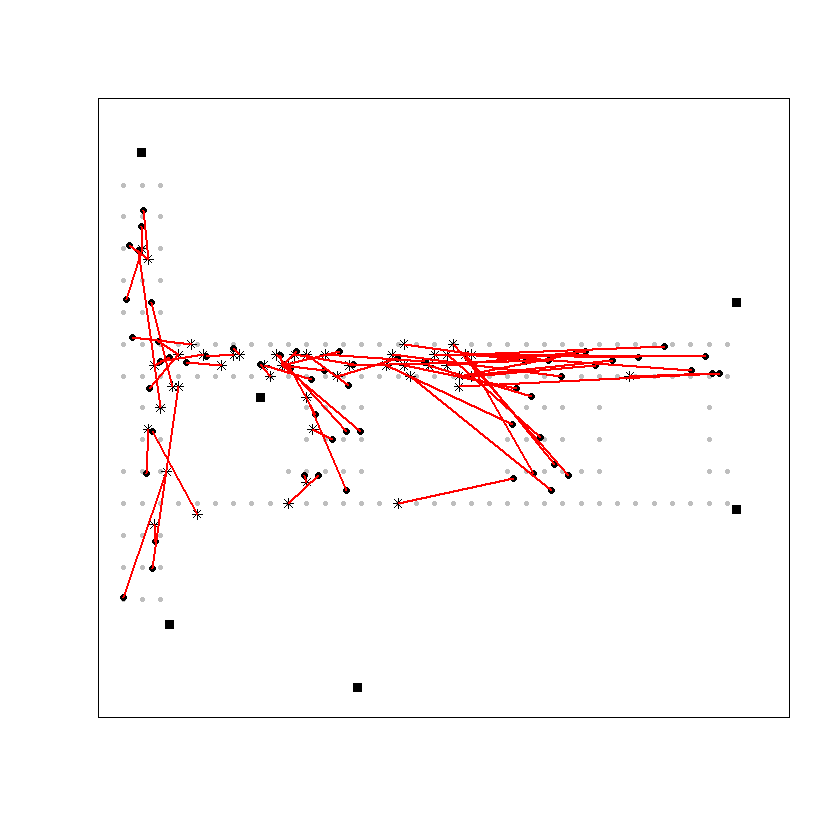

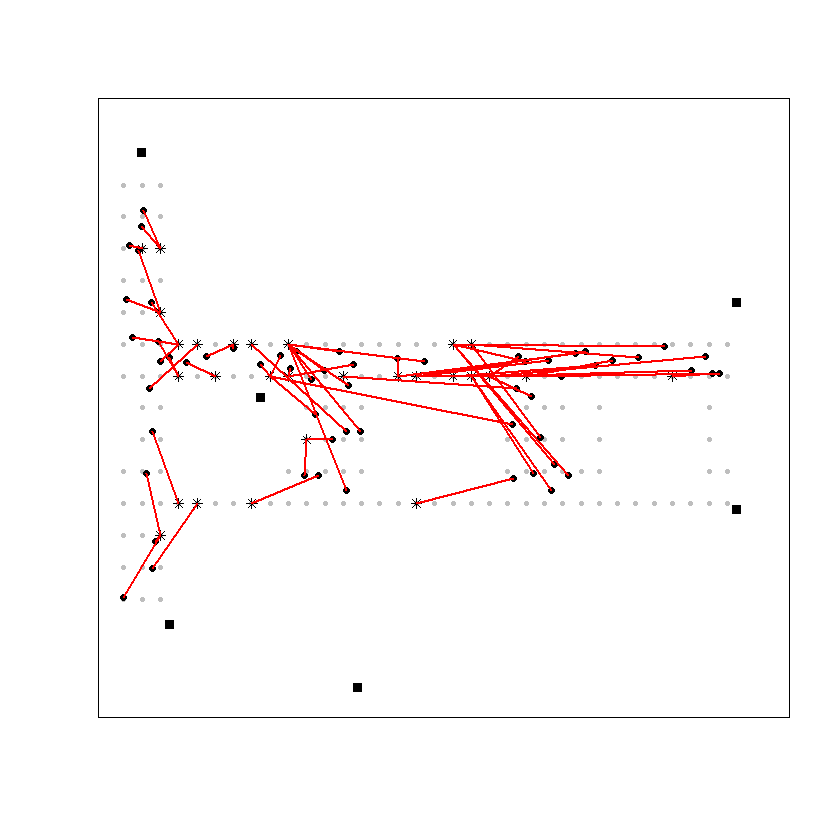

In [46]:
# predict and map errors
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

trainPoints = offlineSummary[ offlineSummary$angle == 0 & 
                              offlineSummary$mac == "00:0f:a3:39:dd:cd" ,
                        c("posX", "posY")]

# 3 NN

floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)


# 1 NN
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)

In [34]:
options(error = recover, warn = 1)
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)
v = 11
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}


[1] 510 244

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"


[1] 126

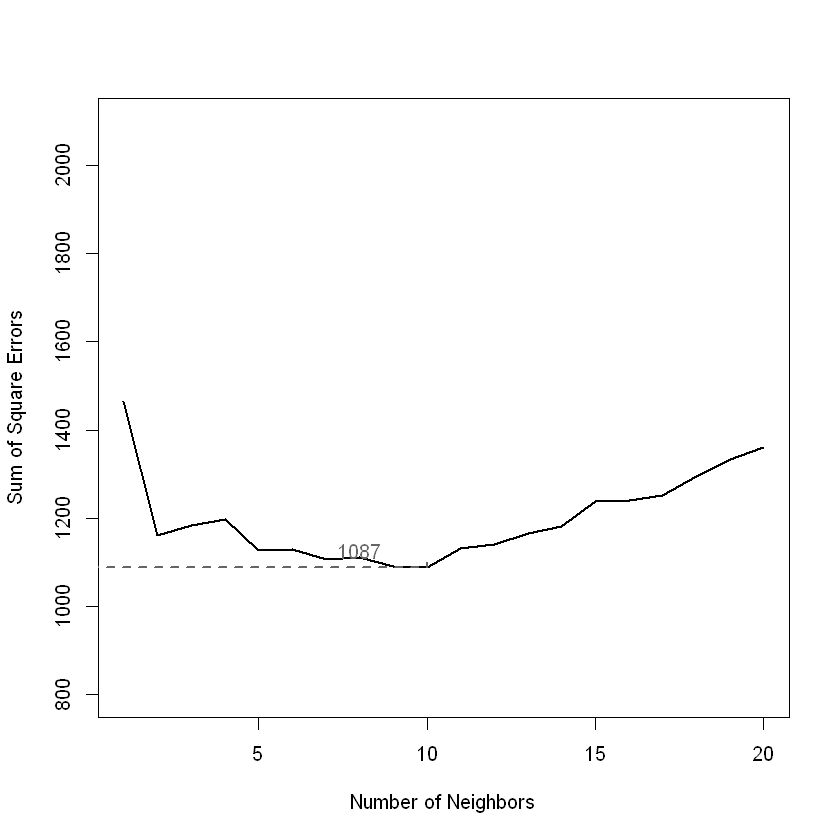

In [48]:
# train model with MAC address "00:0f:a3:39:e1:c0" removed
# up to 20 neighbors, 11 folds
# this one can run for a while (5-10 mins) -- 3 min
# this cell and the next are the same, but the angles change slightly!!
offline = offline[ offline$mac != "00:0f:a3:39:e1:c0", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline, keepVars = keepVars, 
                            sampleAngle = FALSE) # set sampleAngle = FALSE  

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 1, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 1, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}


plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(800, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

In [61]:
estXYk7 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 1, k = 7)

calcError(estXYk7, actualXY)

# error k9 2136.99042345679

[1] 2151

In [14]:
crossValidation <- function(train_full, train_summary, K=20, folds=11, 
                          keepVars = c("posXY", "posX","posY", "orientation", "angle"),
                          Weighted=FALSE, distance = "euclidean") {
  set.seed(51)
  permuteLocs <- sample(unique(train_summary$posXY))
  permuteLocs <- matrix(permuteLocs, ncol = folds, 
                       nrow = floor(length(permuteLocs)/folds))
  onlineCVSummary <- reshapeSS(train_full, keepVars = keepVars, sampleAngle = TRUE)
  err = rep(0, K)
  for (j in 1:folds) {
    onlineFold <- subset(onlineCVSummary, 
                        posXY %in% permuteLocs[ , j])
    offlineFold <- subset(train_summary,
                         posXY %in% permuteLocs[ , -j])
    actualFold <- onlineFold[ , c("posX", "posY")]
    
    for (k in 1:K) {
      if(Weighted == TRUE){
        estFold <- predXYWeighted(newSignals = onlineFold[ , 6:11],
                            newAngles = onlineFold[ , 4], 
                            offlineFold, numAngles = 3, k = k)
        err[k] <- err[k] + calcError(estFold, actualFold)
        
      } else {
        if(distance == "manhattan"){
            
             estFold <- predXYManhattan(newSignals = onlineFold[ , 6:11],
                         newAngles = onlineFold[ , 4], 
                         offlineFold, numAngles = 3, k = k)
            err[k] <- err[k] + calcError(estFold, actualFold)
            
        } else {
            estFold <- predXY(newSignals = onlineFold[ , 6:11],
                             newAngles = onlineFold[ , 4], 
                             offlineFold, numAngles = 3, k = k)
            err[k] <- err[k] + calcError(estFold, actualFold)
            }
      }
    }
  }
  rmseMin <- min(err)
  kMin <- which(err == rmseMin)[1]
  return(list(rmseMin, kMin, err))
}

In [16]:
# head(offlineSummary0)

In [19]:
offline0 = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]
knnResultsModel1 <- crossValidation(offline0, offlineSummary0, K=20)

Warning message in matrix(permuteLocs, ncol = folds, nrow = floor(length(permuteLocs)/folds)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"


In [20]:
print("Results when without MAC 00:0f:a3:39:dd:cd:")
print(paste("Mean Square Error: ",knnResultsModel1[1]," Optimal K: ",knnResultsModel1[2])) 
#seed 25 1038.5 
#seed51 sampleange true 1288.55 #train for quite long
##seed51 sampleange false 616.416666666667  #still train for long
# so decide to keep the setting

[1] "Results when without MAC 00:0f:a3:39:dd:cd:"
[1] "Mean Square Error:  1288.55  Optimal K:  10"


In [21]:
# head(offlineSummary1)

In [22]:
# head(offline1)

In [23]:
offline1 = offline[ offline$mac != "00:0f:a3:39:e1:c0", ]
knnResultsModel2 <- crossValidation(offline1, offlineSummary1, K=20)

Warning message in matrix(permuteLocs, ncol = folds, nrow = floor(length(permuteLocs)/folds)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"


In [24]:
print("Results when without MAC 00:0f:a3:39:e1:c0:")
print(paste("Mean Square Error: ",knnResultsModel2[1]," Optimal K: ",knnResultsModel2[2]))
# seed 25 935
#seed51 sampleange true 1247.

[1] "Results when without MAC 00:0f:a3:39:e1:c0:"
[1] "Mean Square Error:  1247.37190082645  Optimal K:  11"


## Model3 with both MAC

In [32]:

# when keep both data has 7 MACs
reshapeSS <- function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation <-
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x <- x[x$angle == sample(refs, size = 1), ]}
                    ans <- x[1, keepVars]
                    avgSS <- tapply(x[ , varSignal ], x$mac, mean)
                    y <- matrix(avgSS, nrow = 1, ncol = 7,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS <- do.call("rbind", byLocation)
  return(newDataSS)
}

In [33]:
knnResultsModel3 <- crossValidation(offline, offlineSummary, K=20)

Warning message in matrix(permuteLocs, ncol = folds, nrow = floor(length(permuteLocs)/folds)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"


In [25]:
# head(offline)

In [26]:
# head(offlineSummary)

In [34]:
print("Results when without MAC 00:0f:a3:39:e1:c0:")
print(paste("Mean Square Error: ",knnResultsModel3[1]," Optimal K: ",knnResultsModel3[2]))
#seed 25 1100
#seed51 sampleange true 1428

[1] "Results when without MAC 00:0f:a3:39:e1:c0:"
[1] "Mean Square Error:  1428.88888888889  Optimal K:  6"


## Models Comparison

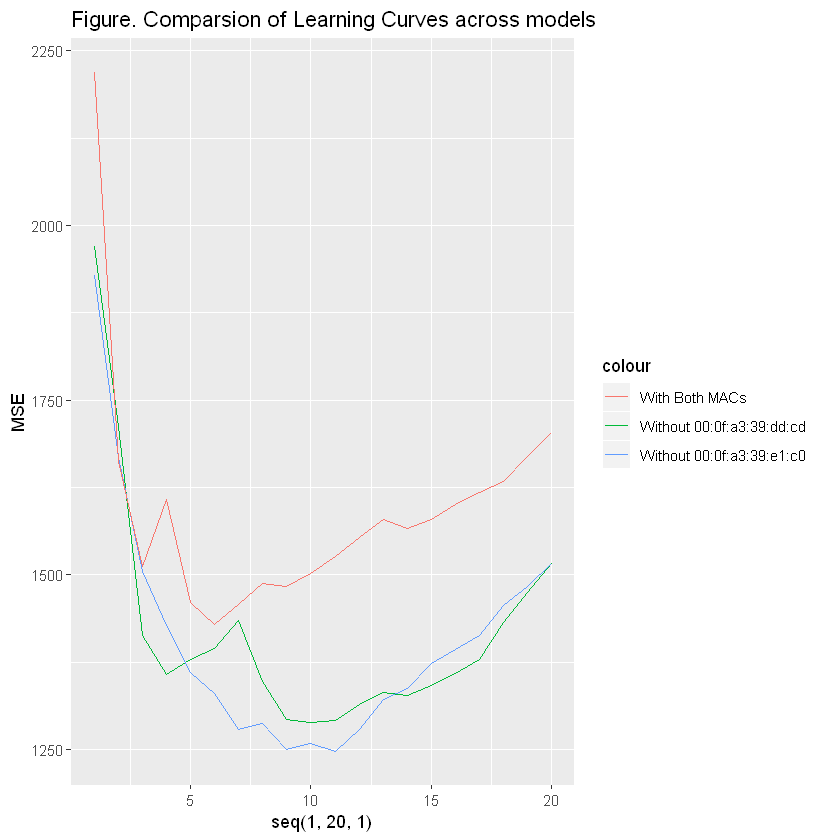

In [65]:
#plot for Model Comparison
library(ggplot2)
k = 20
ggplot()+
  geom_line(mapping=aes(x=seq(1,20,1), y=knnResultsModel1[[3]], color="Without 00:0f:a3:39:dd:cd"), show.legend = TRUE)+
  geom_line(mapping=aes(x=seq(1,20,1), y=knnResultsModel2[[3]], color="Without 00:0f:a3:39:e1:c0"), show.legend = TRUE)+
  geom_line(mapping=aes(x=seq(1,20,1), y=knnResultsModel3[[3]], color="With Both MACs"),  show.legend = TRUE)+
  ggtitle('Figure. Comparsion of Learning Curves across models')+
  labs(y="MSE")

### Results
#### From the plot above, we can see Model2 Without 00:0f:a3:39:e1:c0 yielded the lowest MSE.  (may need to zoom in the fig)
#### Model3 both MAC addresses simultaneously yield less, accurate prediction of location.

## Weighted kNN for the best model above

In [27]:
# function to calculate the distance from the test data to all of the training data and get the top 3 nearest.
findNNWeighted <- function(newSignal, trainSubset) {
  diffs <- apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists <- apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest <- order(dists)
  weight <- as.numeric(1/dists[closest])
  closeXY <- trainSubset[closest, 1:3 ]
  return(cbind(closeXY,weight))
}
                 

In [28]:

# function to get the estimate location 
predXYWeighted <- function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY <- list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS <- selectTrain(newAngles[i], trainData, m = numAngles)
    base <- findNNWeighted(newSignal = as.numeric(newSignals[i, ]), trainSS)
    weights <- append(base[1:k, 4]/sum(base[1:k, 4]), rep(0, nrow(base)-k)) 
    base[, 2:3] = base[, 2:3]*weights # multiply weights array * matrix of x,y to get weighted vals
    closeXY[[i]] = base[,1:3] # append weighted xy, x, y values to list
  }

  estXY <- lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) sum(x)))
  estXY <- do.call("rbind", estXY)
  return(estXY)
}

In [29]:
knnResultsWeighted=crossValidation(offline1, offlineSummary1, K=20 ,Weighted = TRUE)

Warning message in matrix(permuteLocs, ncol = folds, nrow = floor(length(permuteLocs)/folds)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"


In [30]:
print("Results for weighted model")
print(paste("Mean Square Error: ",knnResultsWeighted[1]," Optimal K: ",knnResultsWeighted[2]))

[1] "Results for weighted model"
[1] "Mean Square Error:  1237.72058789667  Optimal K:  11"


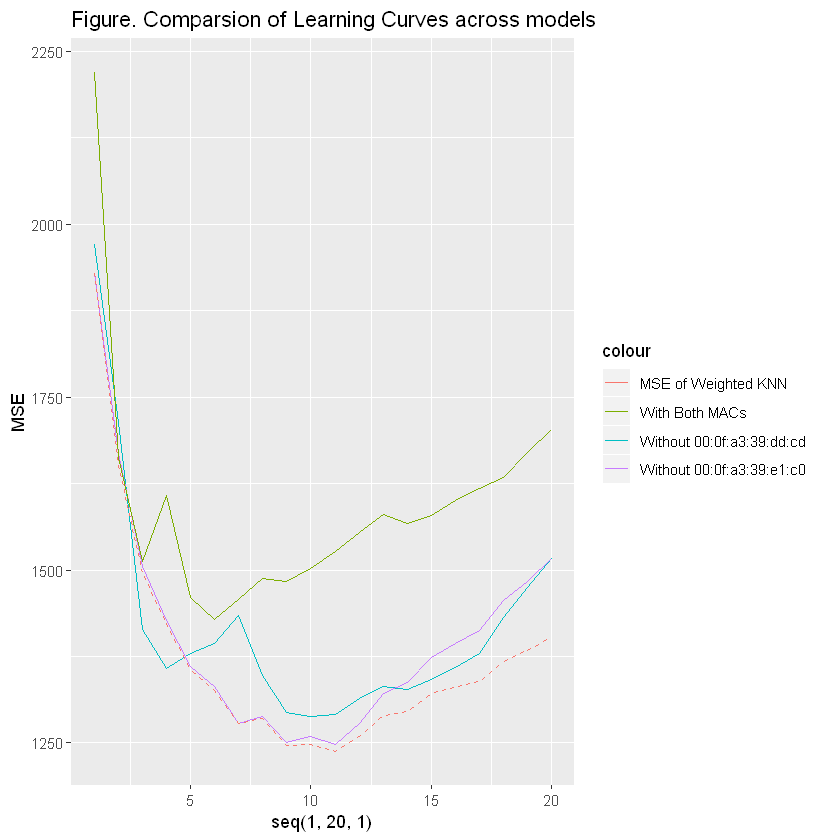

In [36]:
#plot for Model Comparison including weighted model for offline$mac != "00:0f:a3:39:e1:c0",
# please also create a table for Model Comparison (model name, MSE, optimal K) including weighted model
library(ggplot2)
k = 20
ggplot()+
  geom_line(mapping=aes(x=seq(1,20,1), y=knnResultsModel1[[3]], color="Without 00:0f:a3:39:dd:cd"),  show.legend = TRUE)+
  geom_line(mapping=aes(x=seq(1,20,1), y=knnResultsModel2[[3]], color="Without 00:0f:a3:39:e1:c0"), show.legend = TRUE)+
  geom_line(mapping=aes(x=seq(1,20,1), y=knnResultsModel3[[3]], color="With Both MACs"),  show.legend = TRUE)+
  geom_line(mapping=aes(x=seq(1,20,1), y=knnResultsWeighted[[3]], color="MSE of Weighted KNN"), linetype="dashed", show.legend = TRUE)+
  ggtitle('Figure. Comparsion of Learning Curves across models')+
  labs(y="MSE")